<a href="https://colab.research.google.com/github/carnage99/dcgan/blob/main/dcgan_organic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import os 
import os.path
import time
import matplotlib.pyplot as plt

In [ ]:
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3


NUMBER_IMAGES = 28

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/MyDrive/CAPSTONE PROJECT MAIN/GANs/allcirclef'
EPOCHS = 80
BATCH_SIZE = 1
BUFFER_SIZE = 1000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [ ]:
DATA_PATH1 = '/content/drive/MyDrive/CAPSTONE PROJECT MAIN/GANs/allcirclef/allcircle'
print(    len([name for name in os.listdir(DATA_PATH1)])    )

335


In [ ]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'allcircle')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      if image.mode == "RGB":
        training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

  0%|          | 0/335 [00:00<?, ?it/s]

Looking for file: /content/drive/MyDrive/CAPSTONE PROJECT MAIN/GANs/allcirclef/training_data_96_96.npy
Loading training images...


100%|██████████| 335/335 [02:43<00:00,  2.04it/s]

Saving training image binary...


In [ ]:
# Batch and shuffle the data
# training_data has the binary numpy array of all the images
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*1024,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,1024)))

    model.add(UpSampling2D()) #8x8
    model.add(Conv2D(512,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D()) #16x16
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D()) #32x32
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES))) #96x96
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
def save_images(cnt,noise):
  image_array = np.full((NUMBER_IMAGES, GENERATE_SQUARE, GENERATE_SQUARE, 3), 255, dtype = np.uint8)
  
  # after updation of the generator model, send a random noise image and obtain the generated image
  generated_images = generator.predict(noise)
  generated_images = 0.5 * generated_images + 0.5

  image_count = 0;
  for images in image_array:
    images[0:GENERATE_SQUARE, 0:GENERATE_SQUARE] = generated_images[image_count] * 255
    image_count += 1
    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
      os.makedirs(output_path)
    filename = os.path.join(output_path,f"epoch-{cnt}-train-{image_count}.png")
    im = Image.fromarray(images)
    im.save(filename)

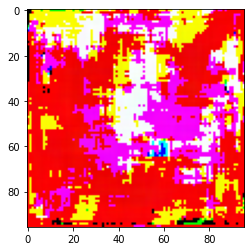

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
img_arr = np.full((NUMBER_IMAGES, GENERATE_SQUARE, GENERATE_SQUARE, 3), 255, dtype = np.uint8)
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
img_arr[0:GENERATE_SQUARE, 0:GENERATE_SQUARE] = generated_image * 255
plt.imshow(img_arr[0, :, :, ])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4999255]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function
def train_step(images):
  #  tf.random.normal(shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None)
  #  32x100 -> each row has 100 normal distrubutions with mean = 0 and stddev = 1
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  # np.random.normal(mean, standard deviation, (28, 100)) -> normal distribution (mean 0, std dev 1) of 28x100
  # has 28 arrays of 100 values each
  # fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
  #                                      SEED_SIZE))
  
  fixed_seed = np.random.normal(0, 1, (NUMBER_IMAGES, SEED_SIZE))

  for epoch in range(epochs):

    gen_loss_list = []
    disc_loss_list = []

    # dataset has entire images that are grouped into batches of 32
    # executes 7864/32 = 250 times for every epoch
    # executes for every batch of np img array in dataset
    # you send 32x100
    for image_batch in dataset:
      t = train_step(image_batch)  # sending in batches of numpy array of images to train_step function, which will return gen loss and disc loss
      # train_step will train the generator by itself

      gen_loss_list.append(t[0])   # this is to just calculate the gen loss and disc loss at the end of every epoch
      disc_loss_list.append(t[1])  # you just append and then take avg later
      
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')

    # executes for 50 times after all epochs
    if(epoch == 10 or epoch == 20 or epoch == 30 or epoch == 40 or epoch == 50 or epoch == 60 or epoch == 70 or epoch == 80):
      save_images(epoch,fixed_seed)

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=1.6131384372711182,disc loss=1.8266539573669434
Epoch 2, gen loss=2.4132466316223145,disc loss=2.0933847427368164
Epoch 3, gen loss=2.2713377475738525,disc loss=2.341966152191162
Epoch 4, gen loss=3.008202314376831,disc loss=2.225043535232544
Epoch 5, gen loss=3.207491159439087,disc loss=2.4345808029174805
Epoch 6, gen loss=3.1321065425872803,disc loss=2.6126840114593506
Epoch 7, gen loss=2.939634323120117,disc loss=2.4756505489349365
Epoch 8, gen loss=3.1636128425598145,disc loss=2.2567758560180664
Epoch 9, gen loss=3.1027722358703613,disc loss=2.504903793334961
Epoch 10, gen loss=3.5175082683563232,disc loss=2.2502365112304688
Epoch 11, gen loss=3.379385232925415,disc loss=2.2633285522460938
Epoch 12, gen loss=3.3094706535339355,disc loss=2.337829113006592
Epoch 13, gen loss=3.8673572540283203,disc loss=2.516649007797241
Epoch 14, gen loss=3.2474780082702637,disc loss=2.160308599472046
Epoch 15, gen loss=3.7723376750946045,disc loss=2.0269558429718018
Epoch 16, gen 

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))
discriminator.save(os.path.join(DATA_PATH, "face_discriminator.h5"))

In [ ]:
# calling the trained model again with appropriate name
# new_generator = tf.keras.models.load_model(os.path.join(DATA_PATH, "face_generator.h5"))